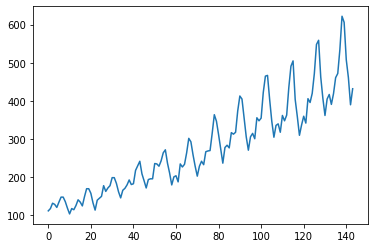

,Passengers
0,112
1,118
2,132
3,129
4,121


In [1]:
# Import librerie base
import pandas
import matplotlib.pyplot as plt

# Data visualization
dataset = pandas.read_csv('airline-passengers.csv', usecols=[1], engine='python')
plt.plot(dataset)
plt.show()
dataset.head()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

# Lib sk-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Lib Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Fissiamo il random seed
np.random.seed(7)

Using TensorFlow backend.


## Caricamento Dataset

In [3]:
# Carica i dati come pandas dataframe
dataframe = pd.read_csv('airline-passengers.csv', usecols=[1], engine='python')

# Estrai i valori scartando indici e header
dataset = dataframe.values

# Forza la conversione a float32 per tutti i valori
dataset = dataset.astype('float32')

# crea oggetto scaler per convertire in intervallo (0, 1)
scaler = MinMaxScaler(feature_range=(0, 1))

# Converti i dati nell'intervallo 0-1
dataset = scaler.fit_transform(dataset)


## Separazione Train-Test Set

In [4]:
# Train = 75% ---- Test = 25%
m_train = int(len(dataset) * 0.75)
train, test = dataset[0:m_train, :], dataset[m_train:-1, :]


In [5]:
# Genera dataset con i label traslati di un time-step
def create_dataset(dataset, look_back=1):
    
    # Inizializza le liste
    dataX, dataY = [], []
    
    # dataX = dati effettivi
    # dataY = dati traslati di un timestep avanti
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    
    # Ritorna i vettori sottoforma di np-array
    return np.array(dataX), np.array(dataY)

In [6]:
# Utilizzando la funzione appena definita generiamo
# i dataset con i tempi scalati
look_back = 1
train_X, train_Y = create_dataset(train, look_back)
test_X, test_Y = create_dataset(test, look_back)

LSTM si aspetta come input dati in forma [samples, time-steps, features], attualmente i nostri dati sono in forma [samples, features] quindi dobbiamo rishaparli.

In [7]:
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

## Costruzione del Network-LSTM
Il modello avrà:
- 1 layer visibile con 1 input
- 1 hidden layer con 4 LSTM-NEURONS
- 1 output layer che predice 1 output<br>

Viene utilizzato la funzione di default sigmoid e il network sarà allenato per 100 epoch con un batch_size=1.

In [8]:
# Crea e fitta il network LSTM

# Crea modello
model = Sequential()

# Aggiungi i 4 neuroni del Hidden-Layer
model.add(LSTM(10, input_shape=(1, look_back)))

# Aggiungi il neurone dell'ultimo layer (output)
model.add(Dense(1))

# Compila il modello
model.compile(loss='mean_squared_error', optimizer='adam')

# fitta il modello col training-set
model.fit(train_X, train_Y, epochs=100, batch_size=1, verbose=2)


Epoch 1/100
 - 0s - loss: 0.0564
Epoch 2/100
 - 0s - loss: 0.0243
Epoch 3/100
 - 0s - loss: 0.0193
Epoch 4/100
 - 0s - loss: 0.0170
Epoch 5/100
 - 0s - loss: 0.0147
Epoch 6/100
 - 0s - loss: 0.0126
Epoch 7/100
 - 0s - loss: 0.0105
Epoch 8/100
 - 0s - loss: 0.0087
Epoch 9/100
 - 0s - loss: 0.0069
Epoch 10/100
 - 0s - loss: 0.0055
Epoch 11/100
 - 0s - loss: 0.0045
Epoch 12/100
 - 0s - loss: 0.0036
Epoch 13/100
 - 0s - loss: 0.0032
Epoch 14/100
 - 0s - loss: 0.0029
Epoch 15/100
 - 0s - loss: 0.0027
Epoch 16/100
 - 0s - loss: 0.0027
Epoch 17/100
 - 0s - loss: 0.0027
Epoch 18/100
 - 0s - loss: 0.0026
Epoch 19/100
 - 0s - loss: 0.0027
Epoch 20/100
 - 0s - loss: 0.0026
Epoch 21/100
 - 0s - loss: 0.0026
Epoch 22/100
 - 0s - loss: 0.0027
Epoch 23/100
 - 0s - loss: 0.0026
Epoch 24/100
 - 0s - loss: 0.0026
Epoch 25/100
 - 0s - loss: 0.0026
Epoch 26/100
 - 0s - loss: 0.0026
Epoch 27/100
 - 0s - loss: 0.0027
Epoch 28/100
 - 0s - loss: 0.0026
Epoch 29/100
 - 0s - loss: 0.0026
Epoch 30/100
 - 0s - lo

In [9]:
# Fai predizione
train_predict = model.predict(train_X)
test_predict = model.predict(test_X)

# Inverti lo scaler per riportare i dati in forma originale

# Y veri
train_Y = scaler.inverse_transform([train_Y])
test_Y = scaler.inverse_transform([test_Y])

# Y predetti
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Ricalcola l'MSE nello spazio originale
trainScore = np.sqrt(mean_squared_error(train_Y[0], train_predict[:, 0]))
testScore = np.sqrt(mean_squared_error(test_Y[0], test_predict[:, 0]))

print(f'Train Score: {trainScore}')
print(f'Test Score: {testScore}')


Train Score: 25.406324750592898
Test Score: 49.98272408909321


# Plot delle Predizioni

In [10]:
# shift delle predizioni di training set
train_prediction_plot = np.empty_like(dataset)
train_prediction_plot[:, :] = np.nan
train_prediction_plot[look_back:len(train_predict) + look_back, :] = train_predict

# shift delle predizioni del test set
test_prediction_plot = np.empty_like(dataset)
test_prediction_plot[:, :] = np.nan
test_prediction_plot[len(train_predict)+(look_back*2)+2:len(dataset)-1, :] = test_predict
#print(test_prediction_plot[len(train_predict)+(look_back*2)+2:len(dataset)-1, :].shape)
#print(test_predict.shape)

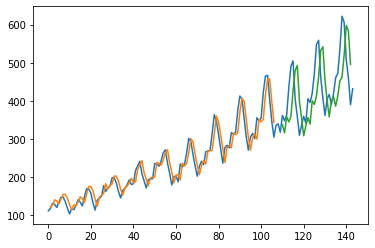

In [11]:
plt.plot(scaler.inverse_transform(dataset))
plt.plot(train_prediction_plot)
plt.plot(test_prediction_plot)
plt.show()